In [1]:
%matplotlib inline

import json

from pathlib import Path
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append(os.path.join(os.getcwd(), os.pardir, 'src'))

%load_ext autoreload

%autoreload 2
from visualization.visualize import *

pd.set_option('display.max_rows', 900)

In [3]:
who_df = pd.read_csv(Path("../data/interim/who_subnational_with_geocodes.csv"), index_col=0)
who_df.head(2)

,Iso Code,Country Name,WHO Region,Year,Vaccine Type,Admin1,Admin2,DenomType,Denominator,Numerator,...,recalc_numerator,available_admin,normalized_country,indicator,group,vaccine,timing,google_admin_1,google_admin_2,place_id
provenance,,,,,,,,,,,,,,,,,,,,,
who0,AFG,Afghanistan,EMRO,2016,BCG,NaN,Aab Band,1.0,1266.0,NaN,...,655.803767,Aab Band,afghanistan,1,BCG,BCG,1st_birth,Ghazni,Ab Band,ChIJ3zPu6yKg1TgRt22VHZjzwm4
who1151,AFG,Afghanistan,EMRO,2016,Pol3,NaN,Aab Band,2.0,1176.0,NaN,...,631.086291,Aab Band,afghanistan,1,Polio,Pol3,4th_14wks_6mos,Ghazni,Ab Band,ChIJ3zPu6yKg1TgRt22VHZjzwm4


In [4]:
who_uga = who_df[who_df['Iso Code'] == 'UGA'].copy()
who_rwa = who_df[who_df['Iso Code'] == 'RWA'].copy()

# Load Uganda DHS

In [5]:
uga_dhs = pd.read_csv(Path("../data/interim/DHS/UGBR7H/UGBR7H.csv"), index_col=0)
rwa_dhs = pd.read_csv(Path("../data/interim/DHS/RWBR70/RWBR70.csv"), index_col=0)

with open(Path("../data/interim/DHS/UGBR7H/UGBR7H.json"), 'r') as f:
    uga_qs = json.load(f)

with open(Path("../data/interim/DHS/RWBR70/RWBR70.json"), 'r') as f:
    rwa_qs = json.load(f)

    
uga_dhs.head(2)

/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (52,54,80,94,129,131,145,146,147,158,159,160,161,162,163,167,218,221,307,308,309,310,311,312,313,314,315,321,323,349,366,367,368,415,436,447,449,453,462,472,473,474,487,493,499,543,544,579,580,581,582,584,585,586,589,601,610,666,684,685,686,688,689,690,709,710,714,717,718,719,721,722,726,729,730,731,733,734,735,745,746,750,751,752,772,775,776,779,780,781,783,784,785,787,788,789,791,792,793,795,796,797,799,800,801,803,804,805,807,808,809,812,815,816,819,820,821,824,827,828,831,832,833,844,845,846,847,848,853,854,855,856,857,858,862,863,864,867,868,869,870,872,873,874,875,876,877,878,879,880,881,882,887,888,889,893,945,946,949,953,954,958,959,960,961,962,963,964,965,966,967,968,975,977,982,983,984,985,988,1018,1021,1024,1027,1039,1048,1052,1069,1070,1071,1075,1077,1078,1079,1080,1081,1082,1083,1084,1085,1087) have mixed types. Specify dtype option on im

,bidx,v000,v001,v002,v003,v004,v005,v006,v007,v008,...,sec11,sec12,sec13,sec14,sec15,sec16,sec17,sec18,sec19,sec20
caseid,,,,,,,,,,,,,,,,,,,,,
00010003 2,1,UG7,1,3,2,1,1099225,8,2016,1400,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00010003 2,2,UG7,1,3,2,1,1099225,8,2016,1400,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Upsample households

 -  `caseid` - unique id per housegold 
 -  `v005` - women's sample weight


In [6]:
def upsample_dhs(df, n_households=10000, seed=6839):
    """ Resamples households for nationally representative coverage
        of women based on `v005`, the women's sample weight.
    """
    # house hold id and household weight
    sampling_weights = df.reset_index()[['caseid', 'v005']].drop_duplicates()
    
    rng = np.random.RandomState(seed)
    
    # choose `n_households` `caseid`s based on `v005` weights 
    households = rng.choice(sampling_weights.caseid,
                            p=sampling_weights.v005 / sampling_weights.v005.sum(),
                            size=n_households)
    
    return df.loc[households, :]

upsampled = upsample_dhs(uga_dhs)

upsampled.head()

,bidx,v000,v001,v002,v003,v004,v005,v006,v007,v008,...,sec11,sec12,sec13,sec14,sec15,sec16,sec17,sec18,sec19,sec20
caseid,,,,,,,,,,,,,,,,,,,,,
00640020 3,1,UG7,64,20,3,64,1121587,7,2016,1399,...,yes,yes,yes,yes,no,yes,yes,yes,no,no
00640020 3,2,UG7,64,20,3,64,1121587,7,2016,1399,...,yes,yes,yes,yes,no,yes,yes,yes,no,no
01080024 2,1,UG7,108,24,2,108,1313437,8,2016,1400,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01080024 2,2,UG7,108,24,2,108,1313437,8,2016,1400,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01080024 2,3,UG7,108,24,2,108,1313437,8,2016,1400,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
def clean_uga_districts(series):
    ss = (series.str.strip()
                    .str.lower()
                    .replace({'ssembabule': 'sembabule'}))
    
    return ss

upsampled.sdistrict = clean_uga_districts(upsampled.sdistrict)
who_uga.Admin2 = clean_uga_districts(who_uga.Admin2)

/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [8]:
from collections import namedtuple

Vax = namedtuple('Vax',
                 ['name',           # Group name
                  'doses_dict',     # map standard WHO dose names to year columns
                  'ever_col',       # yes/no for vax ever given 
                  'ever_col_year']) # year for vax ever given

vaxes = [
    Vax(name='BCG',
        doses_dict={'BCG': ['h2y']},
        ever_col=['h2'],
        ever_col_year=['h2y']),
    
    # DTP or Penta
    Vax(name='DTP',
        doses_dict={'DTP1': ['h3y'],
                    'DTP2': ['h5y'],
                    'DTP3': ['h7y']},
        ever_col=['h3', 'h5', 'h7'],
        ever_col_year=['h3y', 'h5y', 'h7y']),
    
    Vax(name='Measles',
        doses_dict={'MCV1': ['h9y']},
        ever_col=['h9'],
        ever_col_year=['h9y']),
    
]

In [9]:
ever_harmonize_map = {
    'vaccination date on card': 1.0,
    'reported by mother': 1.0,
    'vaccination marked on card': 1.0,
    
    'no': 0.0,
    
    "don't know": np.nan,
}

In [10]:
def calculate_rate(df, vaxes):
    # months old
    months = df.v008 - df.b3

    # less than a year old
    denom = (months > 12) & (months <= 24)
    
    vax_cols = dict(eligible=denom)
    for vax in vaxes:
        # had the immunization
        vaxed = (df[vax.ever_col].replace(ever_harmonize_map) == 1.0).any(axis=1).values.ravel()
        vax_cols[f'vaccinated_{vax.name}'] = vaxed & denom
        
    return pd.DataFrame(vax_cols)
    
vax_rates = calculate_rate(upsampled, vaxes)
unsampled_vax_rates = calculate_rate(uga_dhs, vaxes)

vax_rates.head()

,eligible,vaccinated_BCG,vaccinated_DTP,vaccinated_Measles
caseid,,,,
00640020 3,False,False,False,False
00640020 3,False,False,False,False
01080024 2,False,False,False,False
01080024 2,False,False,False,False
01080024 2,False,False,False,False


In [11]:
uga_dhs.shape

(57906, 1130)

In [12]:
def calculate_district_sums(original_df, unsampled_df, vax_df, unsampled_vax_df):
    vax_cols = [c for c in vax_df.columns if c.startswith('vacc')]
    new_cov_cols = {old: "cov_pct_" + old.split("_")[1] for old in vax_cols}

    district_sums = (pd.concat([original_df[['sdistrict']], vax_df], axis=1)
                       .groupby('sdistrict')
                       .sum())
    
    
    unsampled_sums = (pd.concat([unsampled_df[['sdistrict']], unsampled_vax_df], axis=1)
                       .groupby('sdistrict')
                       .sum())

    # rough max 95% conf interval limits for unsampled data frame
    district_sums['max_sample_uncertainty'] = 1.96 * np.sqrt((0.5 ** 2) / unsampled_sums.eligible)
    
    cov_pcts = district_sums.loc[:, vax_cols].divide(district_sums.eligible, axis=0)

    return pd.concat([district_sums, cov_pcts.rename(columns=new_cov_cols)], axis=1)

district_sums = calculate_district_sums(upsampled, uga_dhs, vax_rates, unsampled_vax_rates)
district_sums.head(2)

,eligible,vaccinated_BCG,vaccinated_DTP,vaccinated_Measles,max_sample_uncertainty,cov_pct_BCG,cov_pct_DTP,cov_pct_Measles
sdistrict,,,,,,,,
abim,4.0,4.0,4.0,4.0,0.295481,1.00,1.00,1.00
adjumani,8.0,6.0,6.0,6.0,0.271803,0.75,0.75,0.75


In [13]:
def get_admin2_coverage(who):
    coverage_by_Admin2 = (who.groupby(['Admin2', 'Vaccine Type'])
                                     [['recalc_numerator', 'Denominator']]
                                        .sum()
                                        .pipe(lambda x: x.recalc_numerator / x.Denominator)
                                        .unstack())

    dtp_cols = list(filter(lambda x: x.startswith('DTP'), coverage_by_Admin2.columns))
    measles_cols = list(filter(lambda x: x.startswith('MCV'), coverage_by_Admin2.columns))
    bcg_cols = list(filter(lambda x: x.startswith('BCG'), coverage_by_Admin2.columns))

    coverage_by_Admin2['recalc_dtp'] = coverage_by_Admin2[dtp_cols].max(axis=1)
    coverage_by_Admin2['recalc_mcv'] = coverage_by_Admin2[measles_cols].max(axis=1)
    coverage_by_Admin2['recalc_bcg'] = coverage_by_Admin2[bcg_cols].max(axis=1)
    
    return coverage_by_Admin2

coverage_by_Admin2 = get_admin2_coverage(who_uga)
coverage_by_Admin2.head(2)

Vaccine Type,BCG,DTP1,DTP3,DTP4,HepB3,HepB_BD,HepB_BDall,Hib3,IPV1,MCV1,...,Pol3,RCV1,Rota1,RotaC,TT2plus,VAD1,YFV,recalc_dtp,recalc_mcv,recalc_bcg
Admin2,,,,,,,,,,,,,,,,,,,,,
abim,0.898608,1.341701,1.603459,0.0,1.603459,0.0,0.0,1.603459,1.161583,1.595231,...,1.538976,0.0,0.0,0.0,NaN,0.741583,0.0,1.603459,1.595231,0.898608
adjumani,0.982809,1.241872,1.215201,0.0,1.215201,0.0,0.0,1.215201,0.623606,1.134478,...,1.075559,0.0,0.0,0.0,NaN,0.715423,0.0,1.241872,1.134478,0.982809


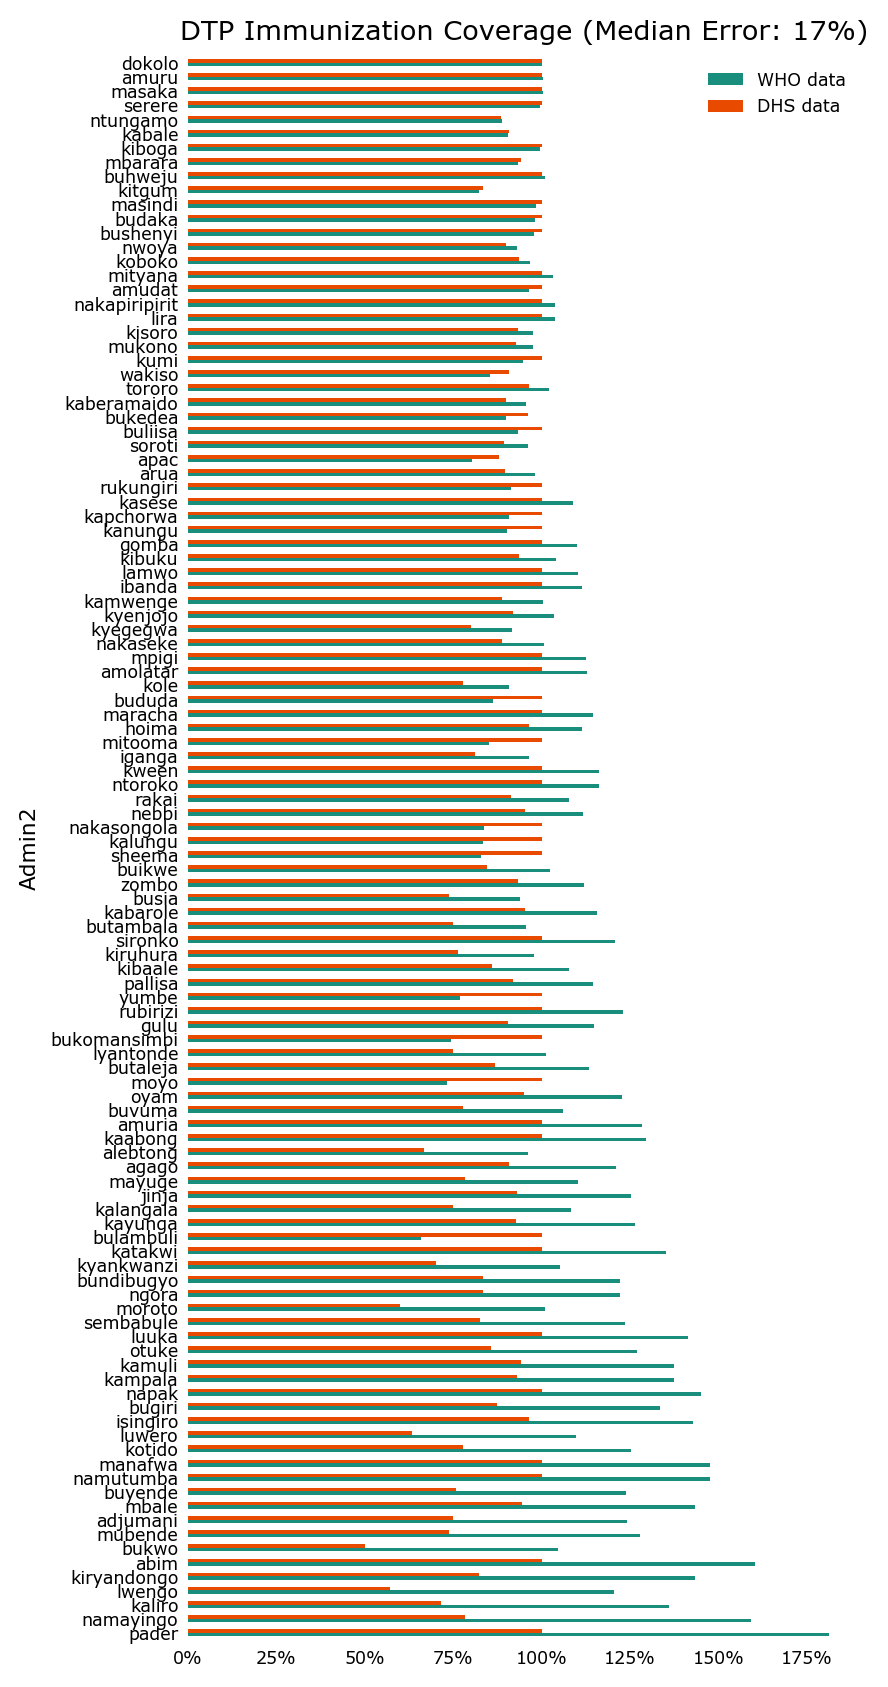

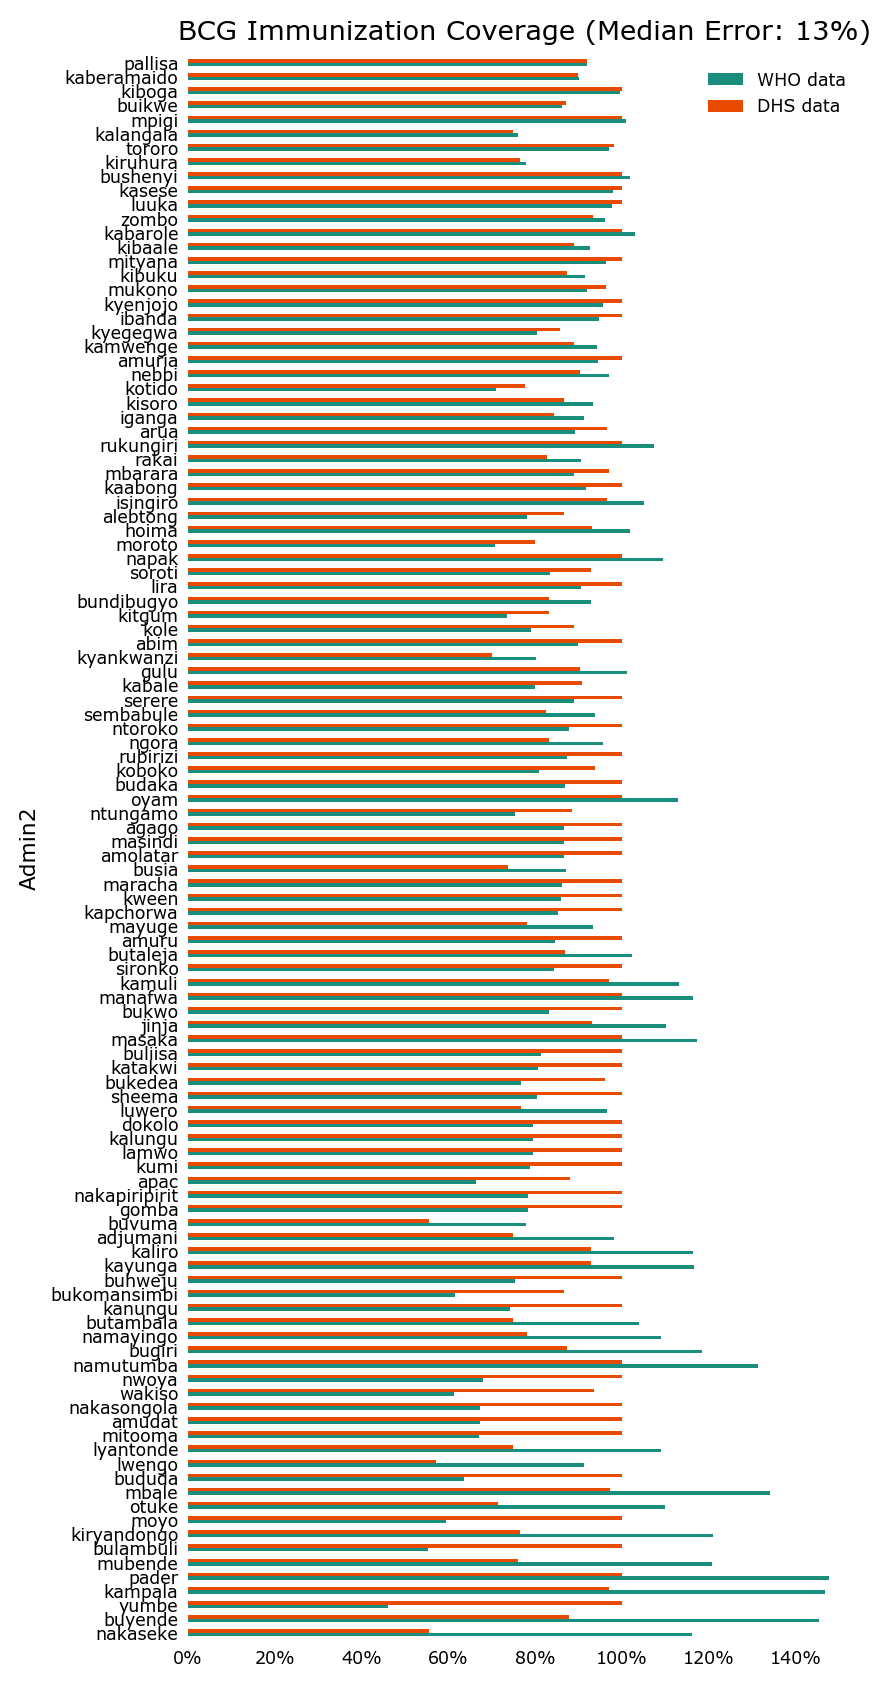

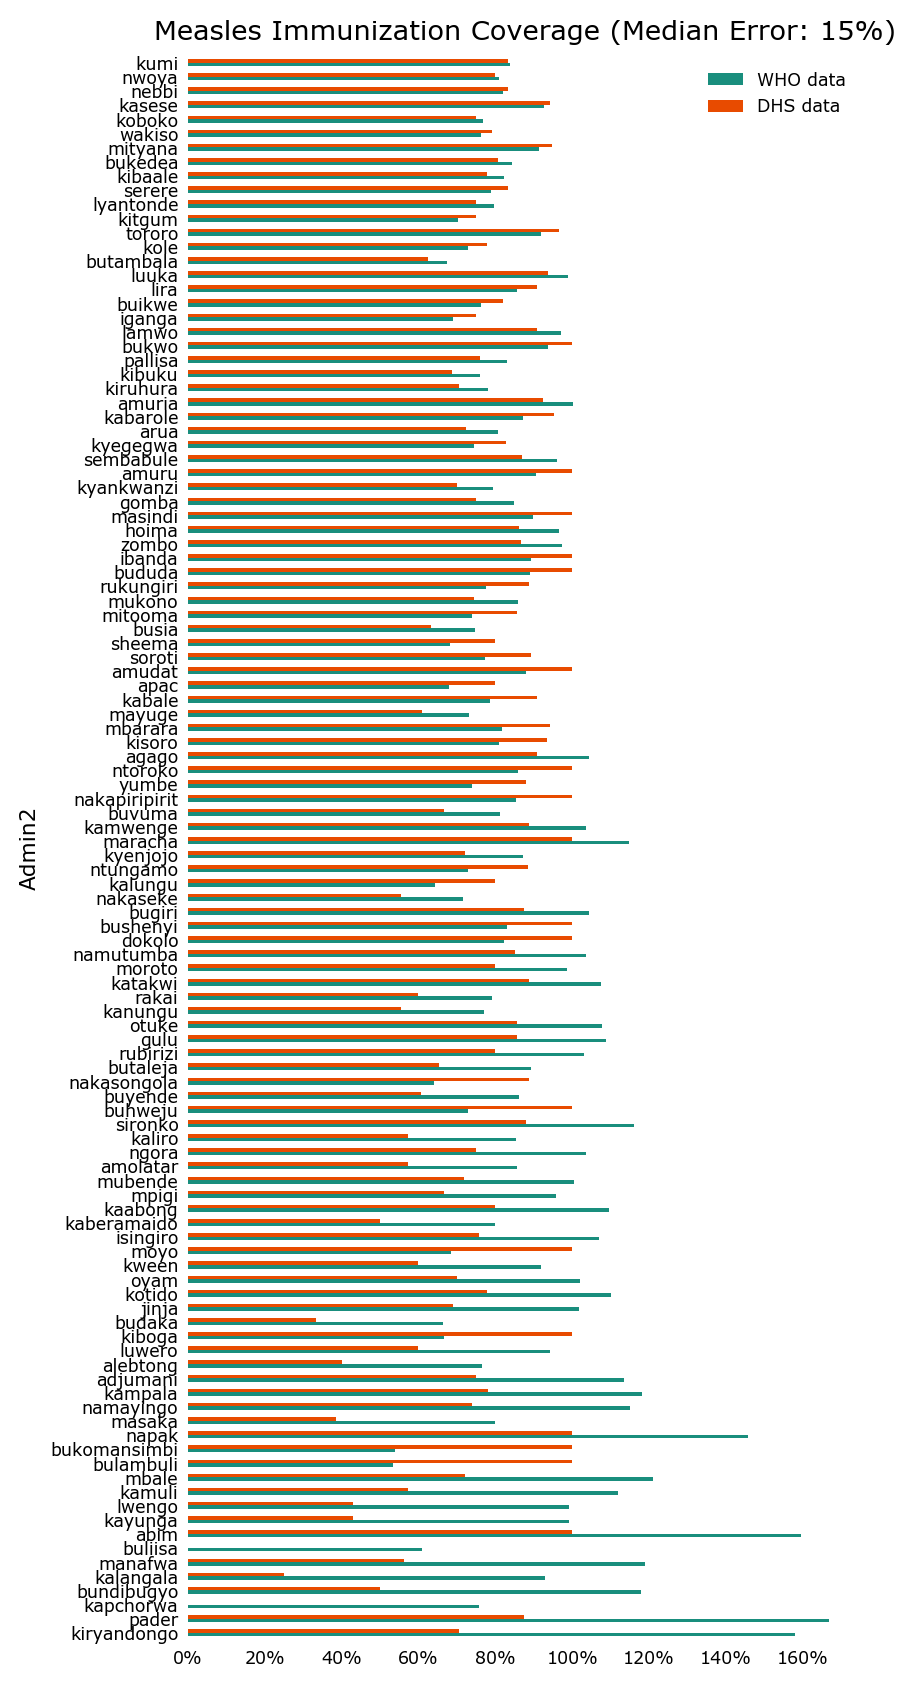

In [14]:
def bar_plot_who_dhs(who_coverage, dhs_coverage):
    plot_together = [
        ('recalc_dtp', 'cov_pct_DTP', "DTP Immunization Coverage"),
        ('recalc_bcg', 'cov_pct_BCG', "BCG Immunization Coverage"),
        ('recalc_mcv', 'cov_pct_Measles', "Measles Immunization Coverage"),
    ]

    for who_col, dhs_col, title in plot_together:
        to_plot = (who_coverage.join(dhs_coverage, how='inner')
                                     [[who_col, dhs_col]])

        reverse_diff_sort = np.argsort((to_plot[who_col] - to_plot[dhs_col]).abs()).values[::-1]
        to_plot = to_plot.iloc[reverse_diff_sort, :]

        to_plot.rename(columns={who_col: 'WHO data', dhs_col: 'DHS data'}, inplace=True)
        
        with styled_fig_ax(size='custom', font_size=8, x_formatter=pct_func_formatter(), zero_lines=False,
                           other_rc_params={'figure.figsize': (4, 8.5)}) as ax:
            to_plot.plot.barh(ax=ax)
            av_err = to_plot.diff(axis=1).abs().median().values[1]
            ax.set_title(title + " (Median Error: {:.0f}%)".format(av_err*100))
            plt.show()
            
            
bar_plot_who_dhs(coverage_by_Admin2, district_sums)

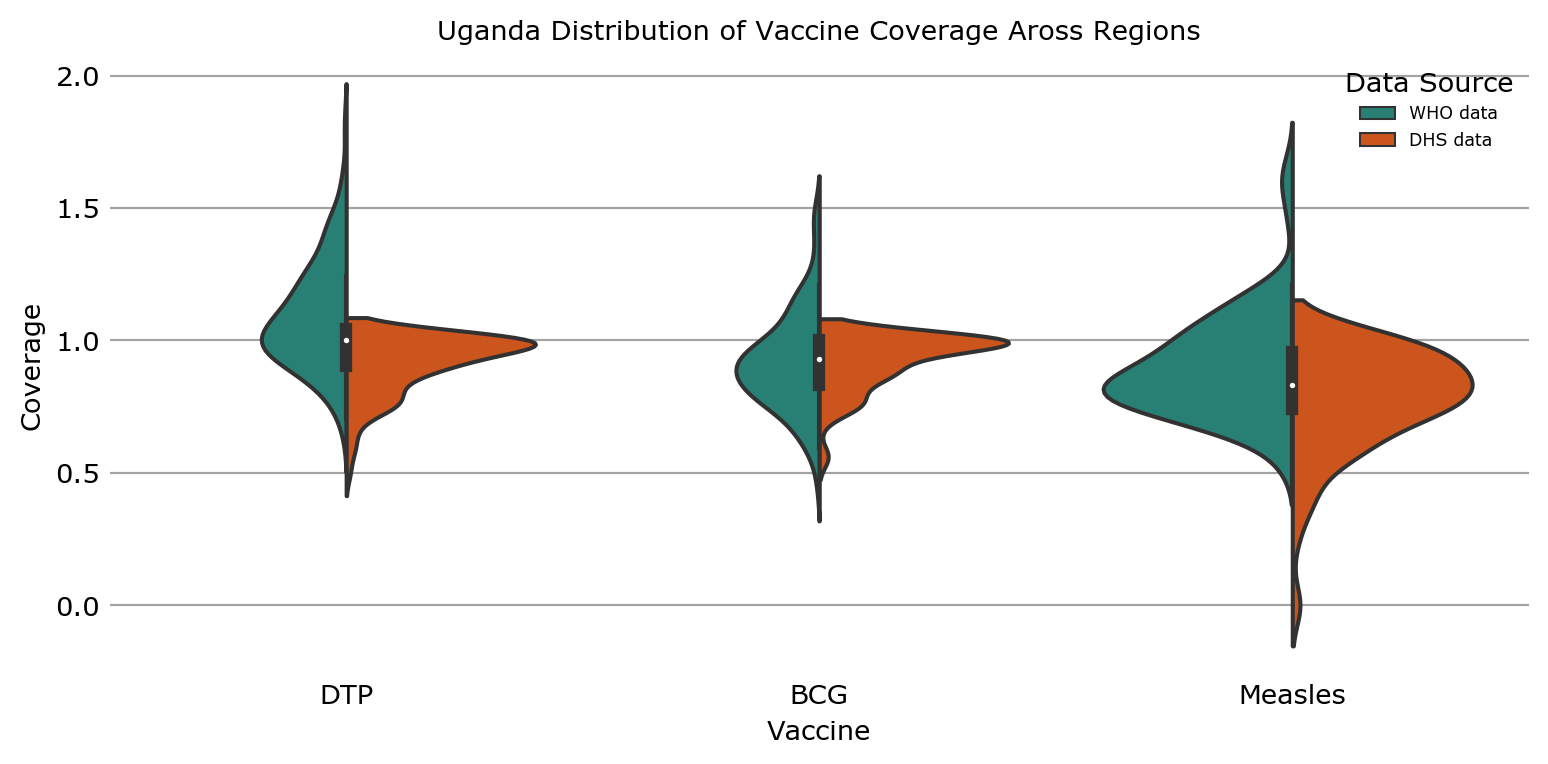

In [15]:
import seaborn as sns

def violin_plot_who_dhs(who_coverage, dhs_coverage, plot_title, ylim=None):
    plot_together = [
        ('recalc_dtp', 'cov_pct_DTP', "DTP"),
        ('recalc_bcg', 'cov_pct_BCG', "BCG"),
        ('recalc_mcv', 'cov_pct_Measles', "Measles"),
    ]

    to_plots = []
    for who_col, dhs_col, title in plot_together:
        to_plot = (who_coverage.join(dhs_coverage, how='inner')
                                     [[who_col, dhs_col]])
        
        to_plot['Vaccine'] = title

        to_plot.rename(columns={who_col: 'WHO data', dhs_col: 'DHS data'}, inplace=True)
        
        to_plot = pd.melt(to_plot,
                          id_vars=['Vaccine'],
                          value_vars=['WHO data', 'DHS data'],
                          value_name='Coverage',
                          var_name='Data Source')
        
        to_plots.append(to_plot)


    final_data = pd.concat(to_plots)
        
    with styled_fig_ax(seaborn=True, size='custom', font_size=8, zero_lines=False,
                       other_rc_params={'figure.figsize': (8, 4)}):

        g = sns.violinplot(data=final_data, x='Vaccine', y='Coverage', hue='Data Source', split=True)
#         g = sns.boxplot(data=final_data, x='Vaccine', y='Coverage', hue='Data Source')
        
        
        g.set_title(plot_title)
        
        if ylim is not None:
            g.set_ylim(ylim)
        
            

violin_plot_who_dhs(coverage_by_Admin2, district_sums, "Uganda Distribution of Vaccine Coverage Aross Regions")

## Same for Rwanda

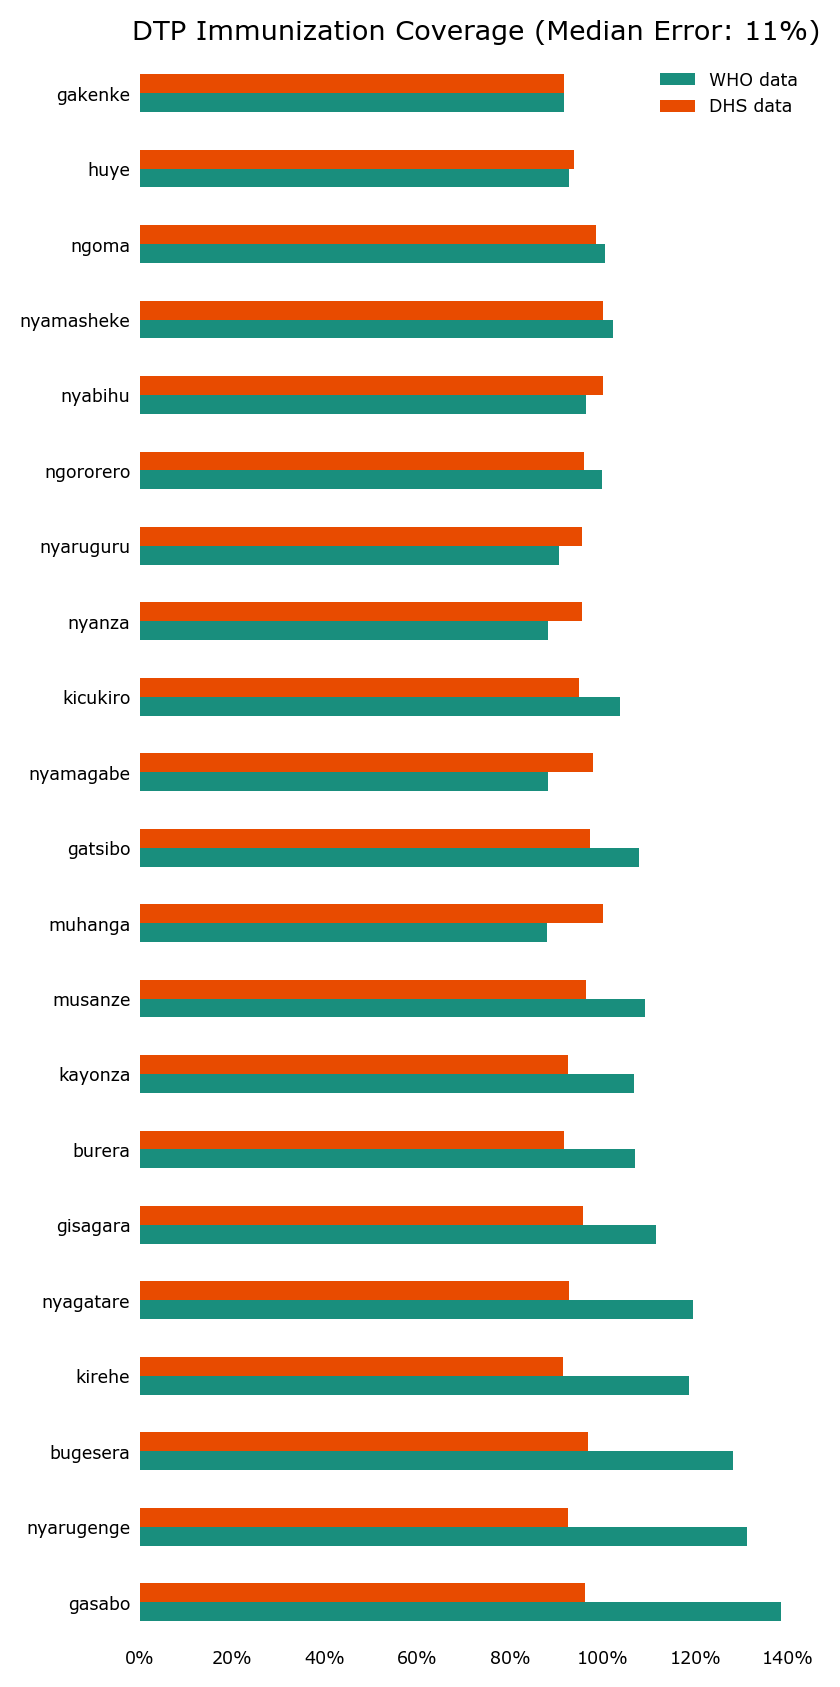

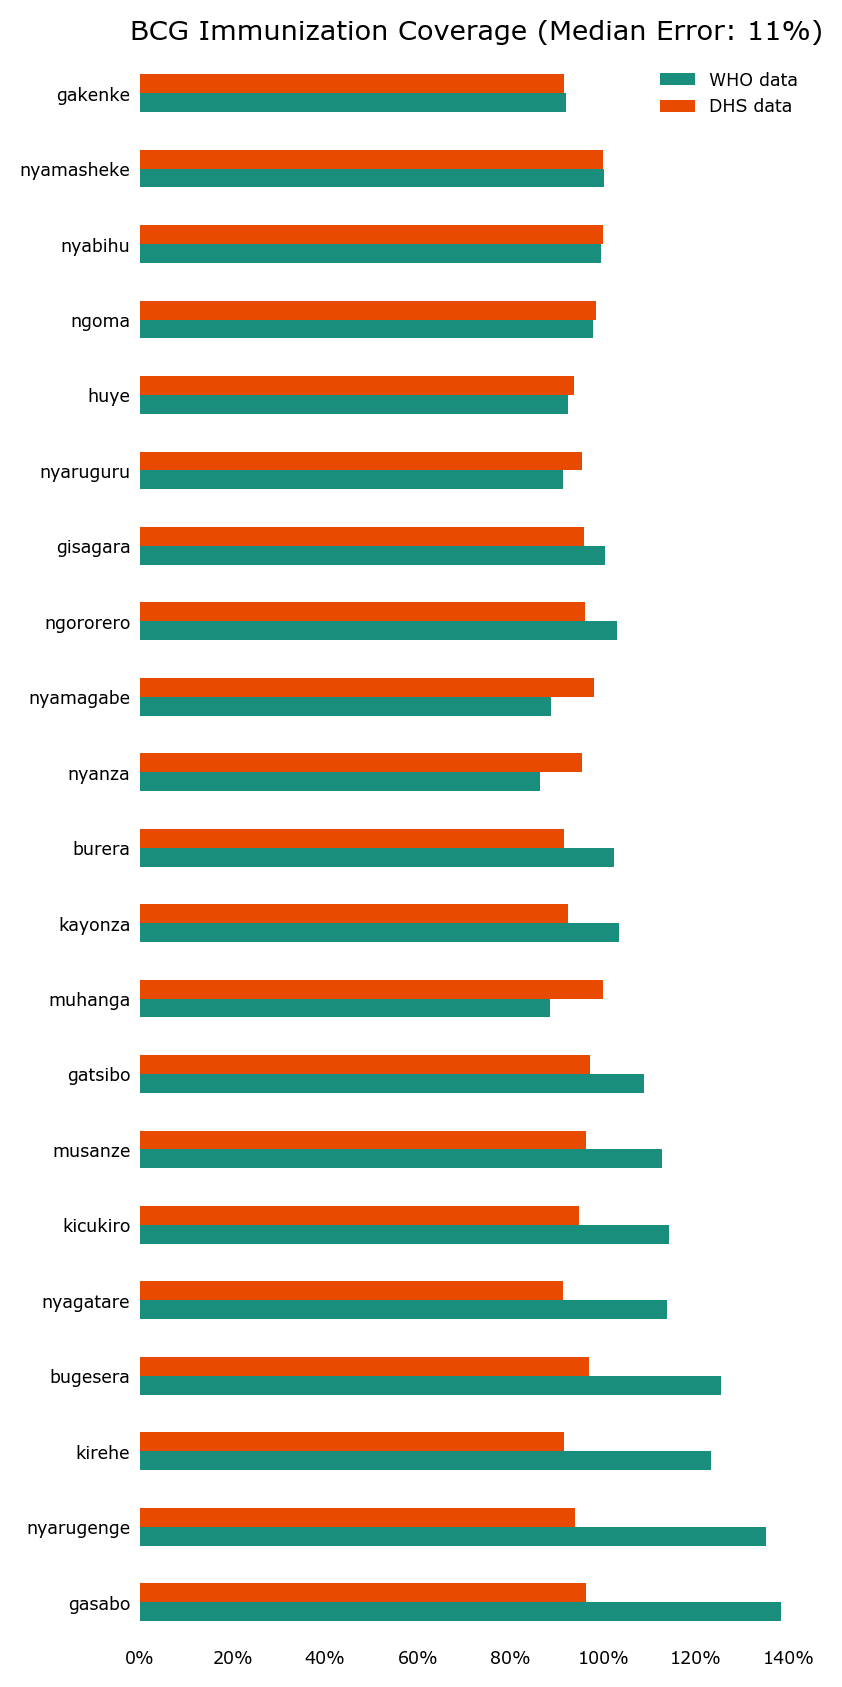

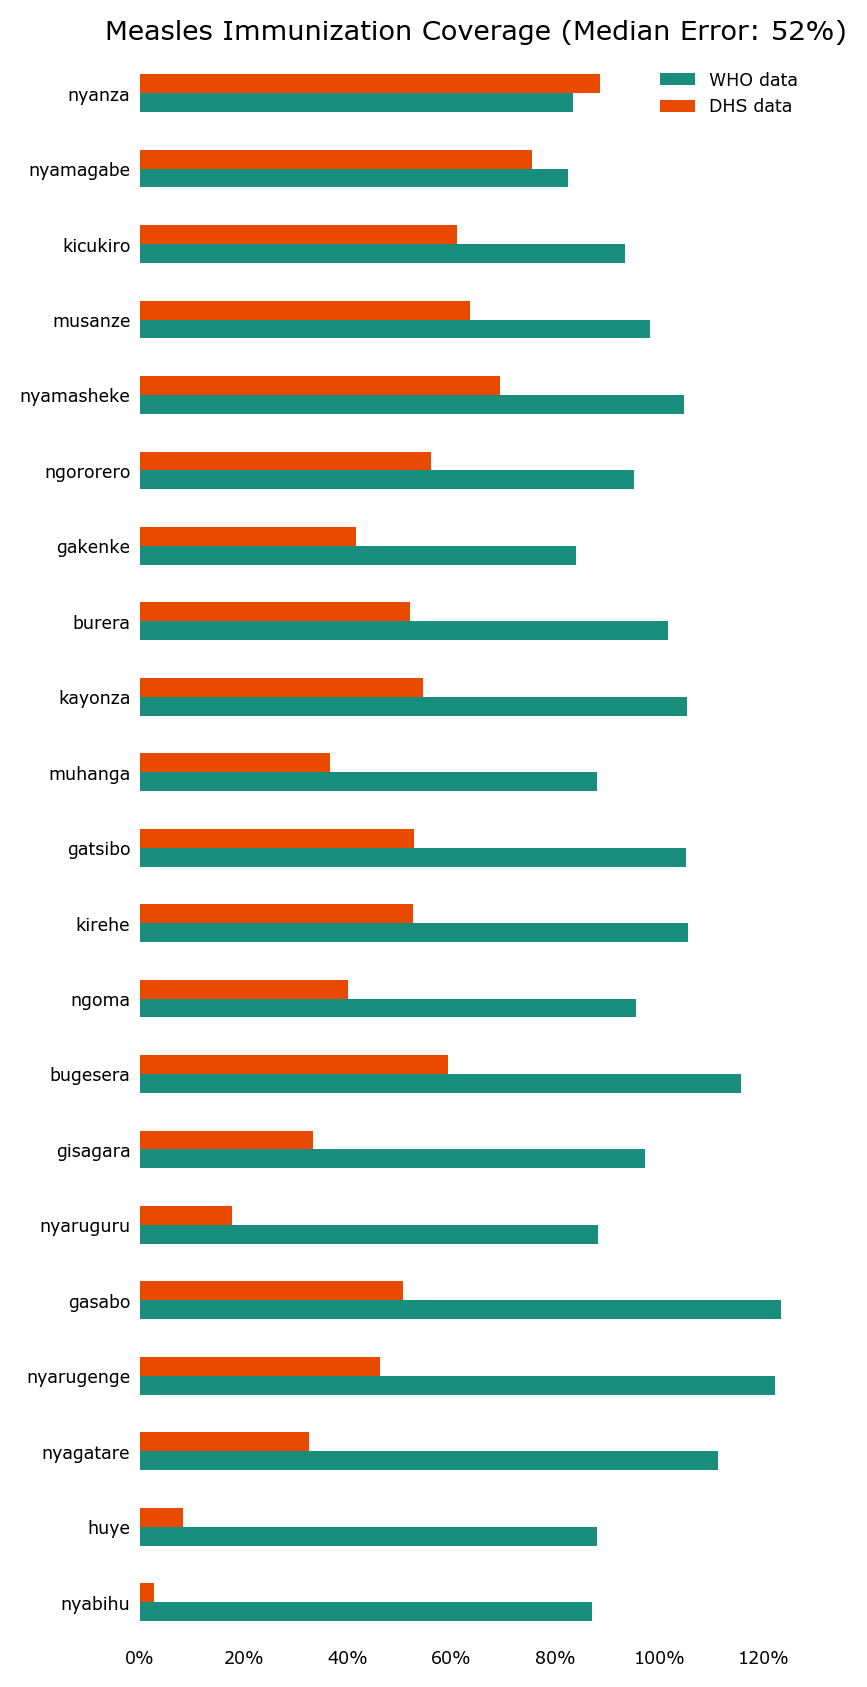

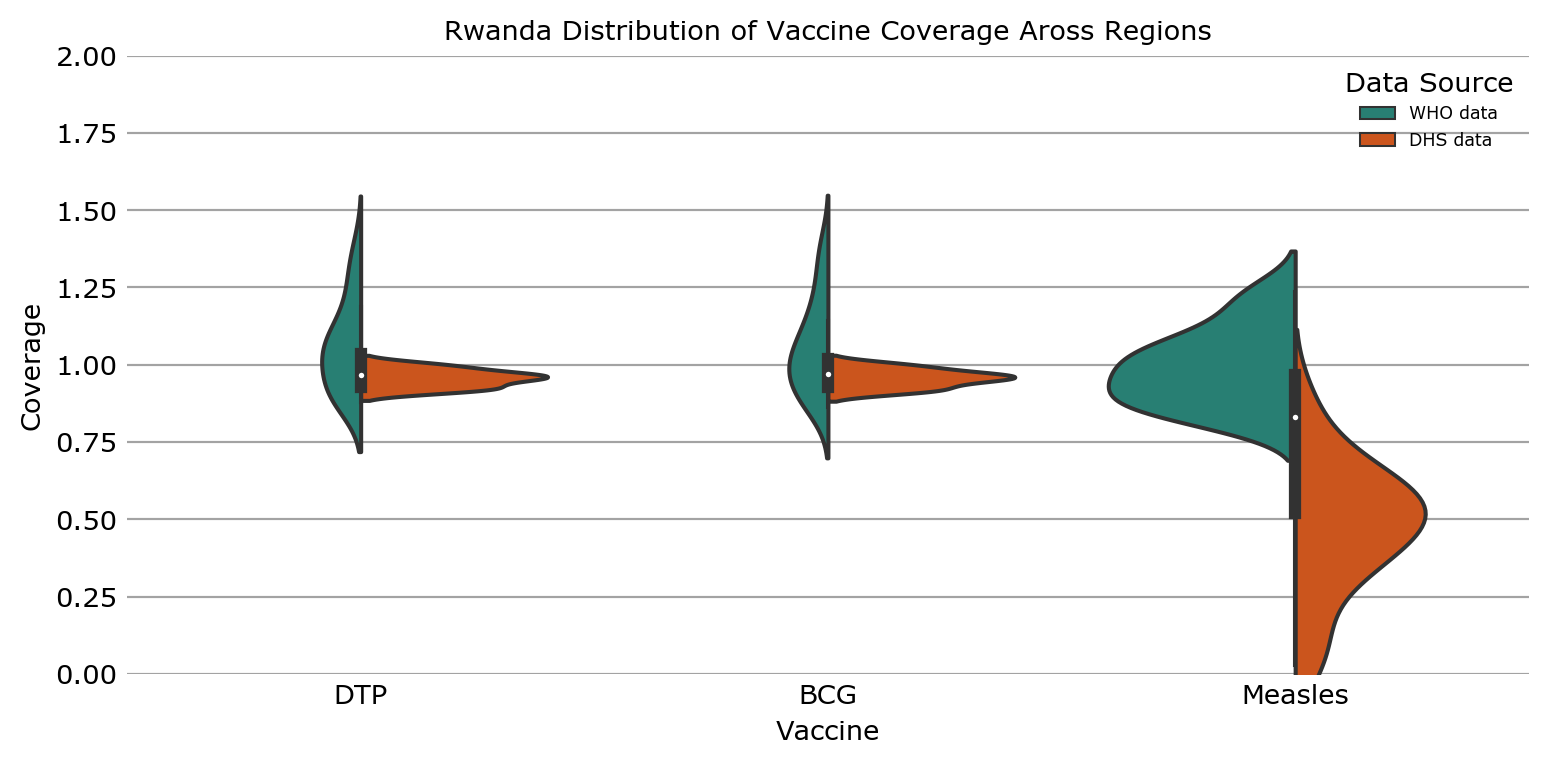

In [16]:
def clean_who_rwa_names(who_names):
    return (who_names.str.strip()
                     .str.lower()
                     .str.strip(" district"))

upsampled = upsample_dhs(rwa_dhs)

# upsampled.sdistrict = clean_uga_districts(upsampled.sdistrict)
who_rwa.Admin2 = clean_who_rwa_names(who_rwa.Admin2)

vax_rates = calculate_rate(upsampled, vaxes)
unsampled_vax_rates = calculate_rate(rwa_dhs, vaxes)

district_sums = calculate_district_sums(upsampled, rwa_dhs, vax_rates, unsampled_vax_rates)

coverage_by_Admin2 = get_admin2_coverage(who_rwa)
bar_plot_who_dhs(coverage_by_Admin2, district_sums)
violin_plot_who_dhs(coverage_by_Admin2,
                    district_sums,
                    "Rwanda Distribution of Vaccine Coverage Aross Regions",
                    ylim=(0, 2.0))

## Inequity

In [17]:
all_series = []
for f in Path("../data/processed/scores/").glob('*.csv'):
    print(f)
    all_series.append(pd.read_csv(f, index_col=0))
    
all_scores = pd.concat(all_series, axis=1)
all_scores.head(2)

../data/processed/scores/country-wb-infant_mortality.csv
../data/processed/scores/country-nasa_pct_diff_of_agg.csv
../data/processed/scores/country-internal-coef_of_var_denom.csv
../data/processed/scores/country-nasa_mean_pct_diff.csv
../data/processed/scores/country-internal-dtp-dropout-agg.csv
../data/processed/scores/country-internal-dtp-dropout-averaged.csv
../data/processed/scores/country-wb-crude_birth_rate.csv
../data/processed/scores/country-internal-coef_of_var.csv
../data/processed/scores/country-weunic_diff_national.csv


,infant_mortality_wb_diff,nasa_pct_diff_of_agg,coef_of_var_denom,nasa_mean_pct_diff,dropout_aggregated,dropout_averaged,crude_birth_rate_wb_diff,coef_of_var,wuenic_mean_difference_from_national
AFG,18.286170,104.205922,0.016016,0.992066,11.649611,14.536052,-3.921798,0.065588,15.333333
AGO,2.472073,1.952697,0.000000,0.663789,12.408592,18.459532,-10.282817,0.213387,10.545455


In [18]:
all_scores.loc['RWA']

infant_mortality_wb_diff                1.814789
nasa_pct_diff_of_agg                    1.925944
coef_of_var_denom                       0.000000
nasa_mean_pct_diff                      0.658230
dropout_aggregated                      2.746829
dropout_averaged                        2.948814
crude_birth_rate_wb_diff               -2.020213
coef_of_var                             0.004811
wuenic_mean_difference_from_national    4.545455
Name: RWA, dtype: float64

In [19]:
all_scores.loc['UGA']

infant_mortality_wb_diff                75.699237
nasa_pct_diff_of_agg                          NaN
coef_of_var_denom                        0.000000
nasa_mean_pct_diff                            NaN
dropout_aggregated                       6.972109
dropout_averaged                         7.417641
crude_birth_rate_wb_diff               -38.144639
coef_of_var                              0.361596
wuenic_mean_difference_from_national    14.111111
Name: UGA, dtype: float64